In [35]:
import numpy as np
import pandas as pd
import xgboost
import lightgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

from sklearn import neighbors


from datetime import datetime
import seaborn as sns
sns.set()
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import decomposition

from sklearn import utils

from sklearn.metrics import mean_squared_error,r2_score


In [2]:
#Reading data
data=pd.read_csv('./data/n1.csv')

In [3]:
data.head(2)

,username,latitude,longitude,noise_value,timestamp,tolerance_level,noise_category,region_category,aqi_value
0,Abhimanyu,22.498528,88.383528,32.6,21-01-2018 02:01,Normal,Traffic,Street/Road,0
1,Abhimanyu,22.498607,88.383522,59.8,21-01-2018 02:01,Normal,Traffic,Street/Road,0


In [4]:
#adding feature for crowded and uncrowded
data['population_type']=data['noise_value'].apply(lambda x: 1 if x>=61 else 0)

In [5]:
data.head(2)

,username,latitude,longitude,noise_value,timestamp,tolerance_level,noise_category,region_category,aqi_value,population_type
0,Abhimanyu,22.498528,88.383528,32.6,21-01-2018 02:01,Normal,Traffic,Street/Road,0,0
1,Abhimanyu,22.498607,88.383522,59.8,21-01-2018 02:01,Normal,Traffic,Street/Road,0,0


In [6]:
data.tail(2)

,username,latitude,longitude,noise_value,timestamp,tolerance_level,noise_category,region_category,aqi_value,population_type
1995,Abhimanyu,22.504107,88.400582,66.7,27-01-2018 02:32,Normal,Traffic,Street/Road,0,1
1996,Abhimanyu,22.504113,88.400557,61.3,27-01-2018 02:32,Normal,Traffic,Street/Road,0,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 10 columns):
username           1997 non-null object
latitude           1997 non-null float64
longitude          1997 non-null float64
noise_value        1997 non-null float64
timestamp          1997 non-null object
tolerance_level    1997 non-null object
noise_category     1997 non-null object
region_category    1997 non-null object
aqi_value          1997 non-null int64
population_type    1997 non-null int64
dtypes: float64(3), int64(2), object(5)
memory usage: 156.1+ KB


In [8]:
data.describe()

,latitude,longitude,noise_value,aqi_value,population_type
count,1997.000000,1997.000000,1997.000000,1997.0,1997.000000
mean,22.498156,88.385192,58.200801,0.0,0.450676
std,0.004231,0.009816,8.717776,0.0,0.497686
min,22.489717,88.368027,8.300000,0.0,0.000000
25%,22.493883,88.376387,54.800000,0.0,0.000000
50%,22.498317,88.384390,60.100000,0.0,0.000000
75%,22.502275,88.394295,64.200000,0.0,1.000000
max,22.504415,88.400582,75.700000,0.0,1.000000


In [9]:
#separating data and time from timespan
data.timestamp=pd.to_datetime(data.timestamp,format='%d-%m-%Y %H:%M')
data['date']=[d.date() for d in data['timestamp']]
data['time']=[d.time() for d in data['timestamp']]

In [10]:
data.head(1)

,username,latitude,longitude,noise_value,timestamp,tolerance_level,noise_category,region_category,aqi_value,population_type,date,time
0,Abhimanyu,22.498528,88.383528,32.6,2018-01-21 02:01:00,Normal,Traffic,Street/Road,0,0,2018-01-21,02:01:00


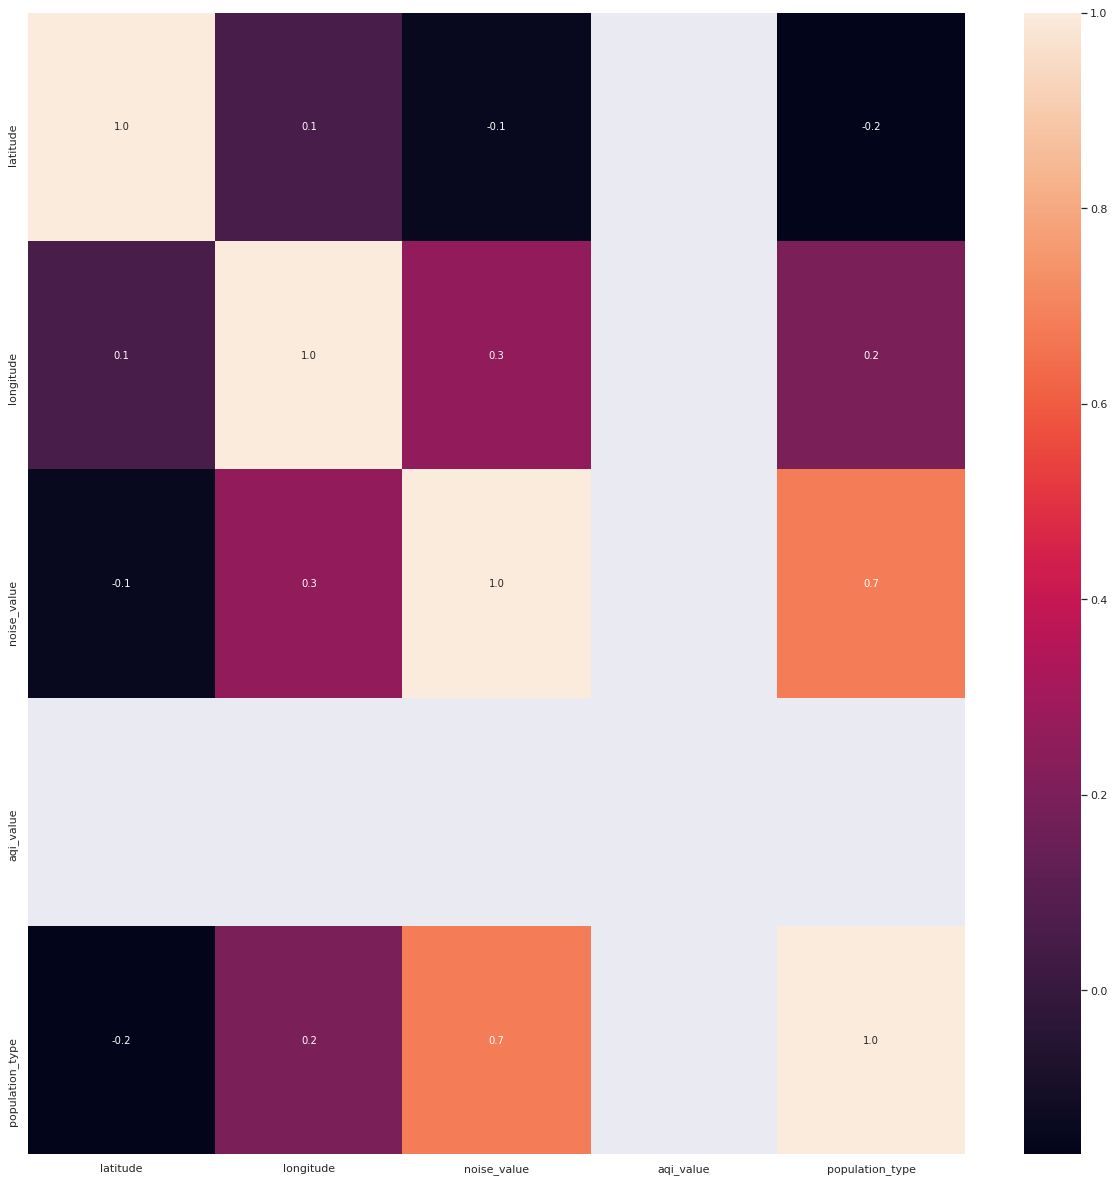

In [11]:
f= plt.subplots(figsize=(21,21))
sns.heatmap(data.corr(),annot=True,fmt='.1f',color='green')

In [12]:
train=data[0:1596]
test=data[1596:]

In [13]:
#train.count()
#test.count()

In [14]:
train_y=train.noise_value
test_y=test.noise_value

In [15]:
columns = ['username','noise_value','tolerance_level','noise_category', 'region_category', 'aqi_value','timestamp','date','time']
train.drop(columns,axis=1,inplace=True)
test.drop(columns,axis=1,inplace=True)

/home/riktim/anaconda3/envs/jde/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
#test.head(1)
train.head(1)

,latitude,longitude,population_type
0,22.498528,88.383528,0


In [17]:
train_X=train
test_X=test

In [18]:
predicted_values=list()
R2_scores=list()
mse_values=list()
regressors=[
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.Lasso(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression(),
    #linear_model.LogisticRegression(),
    linear_model.LassoLars(),
    tree.DecisionTreeRegressor(),
    neighbors.KNeighborsRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(n_estimators=100, max_depth=4),
    xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7),
    CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE'),
    
    ]

In [19]:
for model in regressors:
    model.fit(train_X,train_y)
    predicted_noise=model.predict(test_X)
    predicted_values.append(predicted_noise)
    R2_scores.append(r2_score(predicted_noise,test_y))
    mse_values.append(mean_squared_error(predicted_noise,test_y))


/home/riktim/anaconda3/envs/jde/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/riktim/anaconda3/envs/jde/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), Fu

0:	learn: 51.7769613	total: 52.8ms	remaining: 2.59s
1:	learn: 46.7153133	total: 56.2ms	remaining: 1.35s
2:	learn: 42.2146845	total: 61.6ms	remaining: 965ms
3:	learn: 38.1582726	total: 64.6ms	remaining: 743ms
4:	learn: 34.5377912	total: 67.9ms	remaining: 612ms
5:	learn: 31.2503018	total: 71.1ms	remaining: 522ms
6:	learn: 28.2863051	total: 73.6ms	remaining: 452ms
7:	learn: 25.6406034	total: 76ms	remaining: 399ms
8:	learn: 23.2940687	total: 78.5ms	remaining: 358ms
9:	learn: 21.1654813	total: 81.6ms	remaining: 327ms
10:	learn: 19.2690559	total: 83.9ms	remaining: 298ms
11:	learn: 17.5789204	total: 86.2ms	remaining: 273ms
12:	learn: 16.0736530	total: 88.2ms	remaining: 251ms
13:	learn: 14.7435915	total: 90.9ms	remaining: 234ms
14:	learn: 13.5794608	total: 93.4ms	remaining: 218ms
15:	learn: 12.5428635	total: 96.8ms	remaining: 206ms
16:	learn: 11.6264455	total: 99.1ms	remaining: 192ms
17:	learn: 10.8291491	total: 101ms	remaining: 180ms
18:	learn: 10.0658956	total: 105ms	remaining: 172ms
19:	lea

In [28]:
mse_values

[10.10321607396845,
 5.994265495650634e+25,
 13.485523009655918,
 20.631007124781547,
 13.791673143631531,
 72.18275469707024,
 254.2227673537557,
 13.566916380043548,
 68.10285315066429,
 30.527653089498482,
 15.90279501246882,
 41.44833025768912,
 18.538899621882422,
 22.440023547670563,
 17.083374765382878]

In [29]:
R2_scores

[0.040577878180204086,
 -103365.46712814104,
 0.3767937668523269,
 -1.6810514236885106,
 0.3726990582452001,
 -98.36865692620523,
 -0.44928859462170867,
 0.38116166908605753,
 -1.4987955325294194e+29,
 0.31265029939482814,
 0.08186344522668998,
 0.21379213548959186,
 0.09915644512885846,
 0.2347558578193406,
 0.02854152134566923]

In [30]:
predicted_values

[array([55.19761673, 64.29508191, 64.29505509, 64.29502555, 64.29501963,
        64.29502043, 64.29501318, 64.29497919, 64.29494181, 64.29492369,
        64.29491593, 64.2948895 , 64.2948839 , 55.19736288, 55.197336  ,
        64.29480103, 64.29477913, 64.29476581, 64.29477533, 64.29478058,
        64.29477563, 64.29475634, 64.29472737, 64.29469289, 64.2946621 ,
        64.29464008, 55.19714649, 64.29464151, 64.29463449, 55.19712716,
        64.29457824, 64.29455006, 64.29453333, 64.2945353 , 55.19705843,
        64.29453049, 64.29451656, 64.29450217, 64.29449263, 64.29448418,
        64.2944653 , 64.29444918, 64.29444015, 64.29444281, 64.29444281,
        64.29443386, 64.29442102, 64.29440023, 64.29438877, 64.2943901 ,
        64.29438579, 64.29436395, 55.19694498, 64.29434587, 64.29432259,
        64.29430743, 64.29431053, 64.29430382, 64.2942866 , 64.29425545,
        64.29422499, 64.29419983, 55.19679578, 55.19679577, 64.29417637,
        64.29415491, 64.29412595, 64.29409845, 55.1

In [20]:
#Now all we have to do is plot the graph to show you the boundaries and fault lines

#plot_decision_regions(X=np.array(X), 
                      y=np.array(Y),
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
#plt.xlabel(X.columns[0], size=14)
#plt.ylabel(X.columns[1], size=14)
#plt.title('SVM Decision Region Boundary', size=16)

IndentationError: unexpected indent (<ipython-input-20-fc2959f7aae6>, line 4)

In [51]:
"""from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded_y = lab_enc.fit_transform(train_y)
model=linear_model.LogisticRegression()
model.fit(train_X,encoded_y)
predicted_noise=model.predict(test_X)
#encoded_predicted_value = lab_enc.fit_transform(predicted_noise)
print(utils.multiclass.type_of_target(train_y))
print(utils.multiclass.type_of_target(train_y.astype('int')))
print(utils.multiclass.type_of_target(encoded_y))
"""

"from sklearn import preprocessing\n\nlab_enc = preprocessing.LabelEncoder()\nencoded_y = lab_enc.fit_transform(train_y)\nmodel=linear_model.LogisticRegression()\nmodel.fit(train_X,encoded_y)\npredicted_noise=model.predict(test_X)\n#encoded_predicted_value = lab_enc.fit_transform(predicted_noise)\nprint(utils.multiclass.type_of_target(train_y))\nprint(utils.multiclass.type_of_target(train_y.astype('int')))\nprint(utils.multiclass.type_of_target(encoded_y))\n"

In [52]:
"""model.score(train_X,encoded_y)
print('Coefficient: \n', model.coef_)
print('Intercept: \n', model.intercept_)
"""

"model.score(train_X,encoded_y)\nprint('Coefficient: \n', model.coef_)\nprint('Intercept: \n', model.intercept_)\n"

In [50]:
"""predicted_noise
print(encoded_y.min())
print(encoded_y.max())
print(encoded_y.mean())
print(encoded_y.std())
plt.plot(encoded_y)
plt.figure()

print(predicted_noise.min())
print(predicted_noise.max())
print(predicted_noise.mean())
plt.plot(predicted_noise)
"""

'predicted_noise\nprint(encoded_y.min())\nprint(encoded_y.max())\nprint(encoded_y.mean())\nprint(encoded_y.std())\nplt.plot(encoded_y)\nplt.figure()\n\nprint(predicted_noise.min())\nprint(predicted_noise.max())\nprint(predicted_noise.mean())\nplt.plot(predicted_noise)\n'